In [1]:
import argparse
import csv

import math
import multiprocessing
import os
import random
import sys
from timeit import default_timer as timer
from operator import itemgetter
import dill
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from alipy.data_manipulate.al_split import split
from alipy.experiment.al_experiment import AlExperiment
from alipy.index import IndexCollection
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('seaborn-paper')
#plt.style.use('tex')

font_size = 8

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": font_size,
    "font.size": font_size,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "xtick.bottom":True,
    "figure.autolayout": True,
    
}

sns.set_style('white')
sns.set_context("paper")
plt.rcParams.update(tex_fonts)




# https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width = 505.89





df = pd.read_csv("../datasets/ali/result.csv")
#df.value_counts(subset=['dataset_id'])
#print(len(df))
print(df.strategy.unique())
df['strategy'] = df['strategy'].map({
    "<class '__main__.Uncertainty'>{}":"MM1", 
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True}":"ANNSingle10", 
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True}":"ANNSingle1010", 
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}": "ANNSingle1010New",
    "QueryInstanceUncertainty{'measure': 'margin'}":"MM2", 
    "QueryInstanceUncertainty{'measure': 'least_confident'}":"LC", 
    "QueryInstanceUncertainty{'measure': 'entropy'}":"Ent", 
    "QueryInstanceGraphDensity{}":"GD", 
    "QueryInstanceRandom{}":"Rand", 
    "QueryInstanceQUIRE{}":"QUIRE", 
    "QueryInstanceQBC{}":"QBC", 
    "QureyExpectedErrorReduction{}":"EER", 
    "QueryInstanceLAL{}": "LAL",
    "QueryInstanceSPAL{}": "SPAL",
    "QueryInstanceBMDR{}": "BMDR",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 200, 'TRUE_DISTANCES': True}":"ANNSingle200", 
    "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True}":"NN Batch", 
    "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch.pickle', 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": "NN Batch",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10_cos_nrf.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': True}": "ANNSingleCosNrf",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10_cos.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": "ANNSingleCos",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10_nrf.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': True}" : "ANNSingleNrf",
    "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch_cos_nrf.pickle', 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': True}": "ANNBatchCosNrf",
    "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch_cos.pickle', 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": "NN Batchcos",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": "ANNSingle1010EuclidCos",
    
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 5}": "NNeuc510",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 5}": "NNcos510",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 5, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 5}": "NNeuc55",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 5, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 5}": "NNcos55",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 1}": "NNeuc110",
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False, 'SLIDING_WINDOW': 1}": "NNcos110",
    
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Single1',
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 1, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": 'NN Single1cos',

     "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch.pickle', 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False, 'INITIAL_BATCH_SAMPLING_ARG': 1, 'INITIAL_BATCH_SAMPLING_HYBRID_FURTHEST': 0, 'INITIAL_BATCH_SAMPLING_HYBRID_UNCERT': 0, 'INITIAL_BATCH_SAMPLING_METHOD': 'random'}": 'NN Batch1',
     "<class '__main__.ANNQueryBatch'>{'NN_BINARY_PATH': '/lustre/ssd/ws/s5968580-IL_TD2/ali/batch.pickle', 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False, 'INITIAL_BATCH_SAMPLING_ARG': 1, 'INITIAL_BATCH_SAMPLING_HYBRID_FURTHEST': 0, 'INITIAL_BATCH_SAMPLING_HYBRID_UNCERT': 0, 'INITIAL_BATCH_SAMPLING_METHOD': 'random'}": 'NN Batch1cos'
})

#print(df.dataset_id)

# drop variants
df = df[df.strategy != 'MM1']
#df = df[df.strategy != 'ANNSingle1010']
df = df[df.strategy != 'ANNSingle200']
df = df[df.strategy != 'ANNSingle10']
df = df[df.strategy != 'ANNSingleCosNrf']
df = df[df.strategy != 'ANNSingleNrf']
df = df[df.strategy != 'ANNSingleCos']
df = df[df.strategy != 'ANNBatchCosNrf']
df = df[df.strategy != 'NN Batchcos']

df = df[df.strategy != 'NNeuc510']
df = df[df.strategy != 'NNcos510']
df = df[df.strategy != 'NNeuc55']
df = df[df.strategy != 'NNcos55']
df = df[df.strategy != 'NNeuc110']
df = df[df.strategy != 'NNcos110']

#df = df[df.strategy != 'NN Single1']
#df = df[df.strategy != 'NN Single1cos']
df = df[df.strategy != 'NN Single']
df = df[df.strategy != 'NN Batch1']
df = df[df.strategy != 'NN Batch1cos']



#for i in [13, 16, 21, 24,25,26]:
for i in [22,23,19, 24,25,26]:
    #for i in [22,23,19, 13,16,21]:
    df = df[df.dataset_id != i]

# it is the same as diabetes :(
df = df[df.dataset_id != 9]


df = df[df.dataset_id != 0] # synthetic
df = df[df.dataset_id != 7] # ILPD
df = df[df.dataset_id != 5] # haberman
df = df[df.dataset_id != 1] #BREAST
df = df[df.dataset_id != 28] #parkinsons
#df = df[df.dataset_id != 18] # wine

    
#errors on this dataset
df = df[df.dataset_id != 20]

#toy dataset
df = df[df.dataset_id != 21]

# filter out partial results
df = df[(df.strategy != 'SPAL') | (df.dataset_id != 12)]
df = df[(df.strategy != 'LAL') | (df.dataset_id != 13)]


print(len(df[(df.strategy == 'EER') & (df.dataset_id == 12)]))

# filter out duplicates
df = df.drop_duplicates(subset=['strategy_id', 'dataset_id', 'dataset_random_seed'], keep='last')

df['strategy'] = df['strategy'].replace({
    'MM1':'MM',
    'MM2': 'MM',
    'ANNSingle1010': 'NN Single',
    'ANNSingle1010New': 'NN Single',
})

# every dataset with more than 200 features gets cosine distance!
if True:
    df = df[(df.strategy != 'NN Single') | (df.dataset_id != 12)]
    df = df[(df.strategy != 'NN Single') | (df.dataset_id != 13)]
    df = df[(df.strategy != 'NN Single') | (df.dataset_id != 15)]
    df = df[(df.strategy != 'NN Single') | (df.dataset_id != 16)]
    
    #df = df[(df.strategy != 'NN Single') | (df.dataset_id != 18)]
    #df = df[(df.strategy != 'NN Single') | (df.dataset_id != 19)]
    #df = df[(df.strategy != 'NN Single') | (df.dataset_id != 21)]
    #df = df[(df.strategy != 'NN Single') | (df.dataset_id != 22)]
    #df = df[(df.strategy != 'NN Single') | (df.dataset_id != 23)]
    #df = df[(df.strategy != 'NN Single') | (df.dataset_id != 24)]
    #df = df[(df.strategy != 'NN Single') | (df.dataset_id != 25)]
    #df = df[(df.strategy != 'NN Single') | (df.dataset_id != 26)]
    
    
    #df = df[(df.strategy != 'NNeuc510') | (df.dataset_id != 23)]
    #df = df[(df.strategy != 'NNeuc510') | (df.dataset_id != 15)]
    #df = df[(df.strategy != 'NNeuc510') | (df.dataset_id != 13)]
    df = df[(df.strategy != 'NN Single1') | (df.dataset_id != 15)]
    #df = df[(df.strategy != 'NN Single1') | (df.dataset_id != 12)]
    df = df[(df.strategy != 'NN Single1') | (df.dataset_id != 13)]
    df = df[(df.strategy != 'NN Single1') | (df.dataset_id != 16)]
    
    
    #df = df[(df.strategy != 'NN Batch') | (df.dataset_id != 15)]
    df = df[(df.strategy != 'NN Single1') | (df.dataset_id != 12)]
    #df = df[(df.strategy != 'NN Batch') | (df.dataset_id != 13)]
    #df = df[(df.strategy != 'NN Batch') | (df.dataset_id != 16)]



    
    


    df['strategy'] = df['strategy'].replace({
          'ANNSingle1010EuclidCos': 'NN Single',
          'NN Single1cos': 'NN Single1',
          #'NN Batchcos': 'NN Batch',
        #'NNcos510': 'NNeuc510',
      
    })
    
    


    df['strategy'] = df['strategy'].replace({
          'NN Single1': 'NN Single'
      
    })
    
   


    # use cosine similarity for large datasets
    df = df.drop_duplicates(subset=['strategy', 'dataset_id', 'dataset_random_seed'], keep='last')


df

ModuleNotFoundError: No module named 'dill'

In [ ]:
df.value_counts(subset=['strategy'])

strategy 
Ent          1479
GD           1479
LC           1479
MM           1479
NN Batch     1479
NN Single    1479
QBC          1479
Rand         1479
LAL          1379
EER          1279
QUIRE        1279
BMDR         1179
SPAL         1178
dtype: int64

    strategy dataset_id       duration
172     SPAL          2     350.478815
173     SPAL          3       6.327574
174     SPAL          4     974.737428
175     SPAL          6      25.107502
176     SPAL          8      33.151179
177     SPAL         10      13.336097
178     SPAL         11     227.783949
179     SPAL         14       8.664658
180     SPAL         15      42.856895
181     SPAL         18      19.927786
182     SPAL         27      10.738109
183     SPAL         29      23.586630
188     SPAL         13  604800.000000
190     SPAL         12  604800.000000
194     SPAL         16  604800.000000
      strategy dataset_id     duration
114  NN Single          2    28.360327
115  NN Single          3     6.820913
116  NN Single          4    28.707669
117  NN Single          6    17.829322
118  NN Single          8    20.455070
119  NN Single         10    11.877024
120  NN Single         11    28.421823
121  NN Single         12    30.655202
122  NN Single         13

<AxesSubplot:>

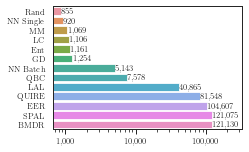

In [ ]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, "{:,.0f}".format(value), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - 0.15
                value = int(p.get_width())
                ax.text(_x, _y, "{:,.0f}".format(value), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


plt.figure(figsize=set_size(width, fraction=0.5))
from numpy import median
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator


df_dur = df.groupby(['strategy', 'dataset_id'])['duration'].mean().to_frame()
df_dur = df_dur.reset_index()  

#print(df_dur.loc[df_dur['strategy']=='Rand'])
#print(df_dur.loc[df_dur['strategy']=='NN Single'])
#print(df_dur.loc[df_dur['strategy']=='MM'])

df_dur2 =  df.groupby(['strategy'])['duration'].mean().to_frame()

timout_duration = 604800
#timout_duration = 259200

# timeout
df_dur = df_dur.append({'strategy':'LAL', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'EER', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'QUIRE', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'BMDR', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'SPAL', 'dataset_id':'13', 'duration':timout_duration}, ignore_index=True)

df_dur = df_dur.append({'strategy':'BMDR', 'dataset_id':'12', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'SPAL', 'dataset_id':'12', 'duration':timout_duration}, ignore_index=True)


df_dur = df_dur.append({'strategy':'EER', 'dataset_id':'16', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'QUIRE', 'dataset_id':'16', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'BMDR', 'dataset_id':'16', 'duration':timout_duration}, ignore_index=True)
df_dur = df_dur.append({'strategy':'SPAL', 'dataset_id':'16', 'duration':timout_duration}, ignore_index=True)


print(df_dur[df_dur['strategy'] == 'SPAL'])
print(df_dur[df_dur['strategy'] == 'NN Single'])

#print(df_dur.loc[df_dur['strategy'] =='LAL']['duration'].mean())

#print(df_dur.loc[df_dur['strategy'] =='Rand']['duration'].mean())

df_hist_new = pd.DataFrame(columns=['strategy', 'duration'])
for strategy in df.strategy.unique():
    df_hist_new = df_hist_new.append({
        'strategy':strategy, 
        'duration': df_dur.loc[df_dur['strategy'] ==strategy]['duration'].mean()
    }, ignore_index=True)

#print(df_hist_new)

df_hist_new = df_hist_new.sort_values(by=['duration'])
g = sns.barplot(data=df_hist_new, x="duration", y="strategy")#, ci=68, capsize=.3)#, fill=True, common_norm=False, alpha=.5, linewidth=0)
show_values_on_bars(g, "h", 10.4)
g.set_xscale("log")
#g.xaxis.set_minor_locator(AutoMinorLocator(5))

#print(g.get_xlim())
g.set_xlim(g.get_xlim()[0],g.get_xlim()[1]+170000)

import matplotlib.ticker
g.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
g.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
g.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

g.xaxis.tick_bottom()
g.set_xlabel("")
#g.set_xlabel("duration in s (walltime)")
g.set_ylabel("")
g.get_figure().savefig('../paper/figures/performance.pdf', format='pdf', bbox_inches='tight')
g


In [ ]:
from tabulate import tabulate


dataset_to_id= {
        0:"synthetic",                                                               
        1:   "breast",                                                                            
        2:   "diabetes",                                                                          
        3:   "fertility",                                                                         
        4:   "german",                                                                            
        5:   "haberman",                                                                          
        6:   "heart",                                                                             
        7:   "ILPD",                                                                              
        8:   "ionosphere",                                                                        
        9:   "pima",                                                                              
        10:   "planning",                                                                         
        11:   "australian",                                                                       
        12:   "DWTC",    
        13: "EMNIST",
        14: "glass",
        15: "olivetti",
        16: "CIFAR-10",
        18: "wine",
        19: "adult50",
        20: "abalone",
        21: "adult1000",
        22: "emnist50",
        23: "cifar1050",
        24: "adult100",
        25: "emnist100",
        26: "cifar10100",
        27: "zoo",
        28: "parkinsons",
        29: "flags",
    
}


#strategy_results = [['strategy', 'synthetic', 'breast', 'diabetes', 'fertility', 'german', 'haberman', 'heart', 'ilpd', 'ionosphere', 'pima', 'planning', 'australian', 'dwtc', 'emnist_test']]#,'mean', 'df_mean', 'df_mean2']]
#strategy_results[0] = strategy_results[0][:len(df.dataset_id.unique())+1]
dataset_names = ['strategy'] + [dataset_to_id[id] for id in df['dataset_id'].unique()]
#print(dataset_names)
#print(strategy_results)
strategy_results = []
strategy_results.append(dataset_names)

def get_ranks(l):
    uniques = np.unique(l)
    argssorted = np.flip(np.argsort(uniques))
    
    mapping = dict(zip(uniques, argssorted))
    ranks = [mapping[x] for x in l]
    return ranks

for strategy in df['strategy'].unique():
    results = [strategy]
    for dataset in df['dataset_id'].unique():
        results.append("{:.4f}".format(df.loc[(df['dataset_id']==dataset) & (df['strategy']==strategy)]['performance'].mean()))
        results = [r if r != "nan" else -1 for r in results] 
    
    #results += [np.mean(np.array(results[1:]).astype(np.float64))]
    
    #results += [df.loc[df['strategy']==strategy]['performance'].mean()]
    #results += [np.mean(df.loc[df['strategy']==strategy].groupby('dataset_id')['performance'].mean())]
    
    
    strategy_results.append(results)

results_df = pd.DataFrame(strategy_results[1:], columns=strategy_results[0])
results_df = results_df.set_index("strategy")
results_df = results_df.replace(-0, np.NaN)
results_df = results_df.apply(pd.to_numeric)

results_df['mean'] = results_df.T.mean(skipna=True)

#results_df = results_df.fillna(value=-1)
#print(results_df)

    
transposed_results = list(map(list, zip(*strategy_results)))
new_results = [transposed_results[0]]
for row in transposed_results[1:]:
    row_sorting = get_ranks(np.array(row[1:]))
    
    row = row[:1] + ["{:.2%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
    new_results.append(row)

row = ["mean"] + results_df['mean'].to_list()
row_sorting = get_ranks(np.array(row[1:]))

row = row[:1] + ["{:.2%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
new_results.append(row)
    
tabulate(new_results, headers="firstrow", tablefmt="html")

strategy,MM,LC,Ent,Rand,GD,QUIRE,QBC,EER,NN Batch,nan,NN Single,LAL,SPAL,BMDR
fertility,90.39% (5),90.39% (5),90.39% (5),89.80% (6),90.65% (3),89.62% (7),90.60% (4),89.02% (8),90.69% (2),-100.00% (9),90.65% (3),90.39% (5),90.95% (0),90.94% (1)
diabetes,74.49% (5),74.49% (5),74.49% (5),74.40% (7),75.20% (0),66.63% (10),74.52% (4),74.33% (8),74.64% (2),-100.00% (11),74.59% (3),74.45% (6),74.03% (9),74.90% (1)
german,75.60% (9),75.60% (9),75.60% (9),75.81% (4),76.38% (1),71.11% (10),75.73% (6),75.61% (8),75.86% (3),-100.00% (11),75.88% (2),75.70% (7),76.71% (0),75.79% (5)
heart,79.33% (6),79.33% (6),79.33% (6),79.33% (6),79.50% (4),74.82% (9),79.32% (7),79.37% (5),79.61% (1),-100.00% (10),79.65% (0),79.56% (3),78.90% (8),79.60% (2)
ionosphere,90.43% (1),90.43% (1),90.43% (1),90.00% (6),90.05% (5),53.54% (10),90.28% (3),89.81% (7),89.73% (8),-100.00% (11),90.96% (0),90.29% (2),83.62% (9),90.17% (4)
planning,72.68% (3),72.68% (3),72.68% (3),69.05% (9),70.20% (7),71.99% (6),73.34% (2),68.85% (10),74.63% (0),-100.00% (11),72.58% (4),72.09% (5),74.24% (1),69.54% (8)
australian,85.59% (0),85.59% (0),85.59% (0),85.12% (6),85.40% (3),76.33% (9),85.51% (1),84.79% (7),85.48% (2),-100.00% (10),85.59% (0),85.36% (4),84.53% (8),85.33% (5)
DWTC,75.12% (1),71.35% (7),68.89% (8),73.29% (3),65.45% (9),53.55% (10),72.09% (6),73.23% (4),74.55% (2),-100.00% (11),75.29% (0),72.56% (5),-100.00% (11),-100.00% (11)
EMNIST,69.50% (0),61.64% (5),59.26% (6),66.14% (3),43.82% (7),-100.00% (8),63.42% (4),-100.00% (8),68.67% (2),-100.00% (8),69.13% (1),-100.00% (8),-100.00% (8),-100.00% (8)
glass,69.47% (1),68.84% (3),67.23% (8),68.51% (4),67.33% (7),48.42% (11),68.43% (5),68.07% (6),68.98% (2),-100.00% (12),69.71% (0),66.91% (9),62.63% (10),68.51% (4)


In [ ]:
from tabulate import tabulate

#strategy_results = [['strategy', 'synthetic', 'breast', 'diabetes', 'fertility', 'german', 'haberman', 'heart', 'ilpd', 'ionosphere', 'pima', 'planning', 'australian', 'dwtc', 'emnist']]#,'mean', 'df_mean', 'df_mean2']]
#strategy_results[0] = strategy_results[0][:len(df.dataset_id.unique())+1]
strategy_results = []
strategy_results.append(dataset_names)
#results_df.loc['NN Single', 'fertility'] = 2

def get_ranks(l):
    uniques = np.unique(l)
    argssorted = np.flip(np.argsort(uniques))
    mapping = dict(zip(uniques, argssorted))
    ranks = [mapping[x] for x in l]
    
    m2 = {}
    last_value = -1
    increase = 0
    for i, v in enumerate(sorted(ranks)):
        if last_value == v:
            increase += 1
            m2[v] = v
        else:
            m2[v] = v+increase
        last_value = v
    
    #ranks = [m2[x] for x in ranks]
    return ranks

for strategy in df['strategy'].unique():
    results = [strategy]
    for dataset in df['dataset_id'].unique():
        results.append("{:.40f}".format(df.loc[(df['dataset_id']==dataset) & (df['strategy']==strategy)]['f1_auc'].mean()))
        
        # count how often per dataset
        #results.append("{}".format(len(df.loc[(df['dataset_id']==dataset) & (df['strategy']==strategy)])))
        
        results = [r if r != "nan" else -0 for r in results] 
    
    #results += [np.mean(np.array(results[1:]).astype(np.float64))]
    
    #results += [df.loc[df['strategy']==strategy]['performance'].mean()]
    #results += [np.mean(df.loc[df['strategy']==strategy].groupby('dataset_id')['performance'].mean())]
    
    
    strategy_results.append(results)

#print(strategy_results[10][2])
#strategy_results[10][2] = 0.94
#print(strategy_results[10])
    
    
results_df = pd.DataFrame(strategy_results[1:], columns=strategy_results[0])
results_df = results_df.set_index("strategy")
results_df = results_df.replace(-1, np.NaN)
results_df = results_df.apply(pd.to_numeric)

results_df['mean'] = results_df.T.mean(skipna=True)

#results_df = results_df.fillna(value=-1)
#print(results_df)

ranking_only_table = []
transposed_results = list(map(list, zip(*strategy_results)))
new_results = [transposed_results[0]]
for row in transposed_results[1:]:
    row_sorting = get_ranks(np.array(row[1:]))
    row = row[:1] + ["{:.1%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
    new_results.append(row)
    ranking_only_table.append(row[:1] + row_sorting)

row = ["mean %"] + results_df['mean'].to_list()
row_sorting = get_ranks(np.array(row[1:]))

row = row[:1] + ["{:.1%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
new_results.append(row)


ranking_only_table = [transposed_results[0]] + ranking_only_table
new_results.append(["mean (r)"] + ["{:1.2f}".format(sum(r)/len(r)) for r in list(map(list, zip(*ranking_only_table[1:])))[1:]])


# sort colmuns manually
df2 = pd.DataFrame(new_results[1:], columns=new_results[0])
#df2 = df2[['strategy', 'ANNSingle1010EuclidCos', 'ANNSingleCosNrf', 'ANNSingleCos', 'ANNSingleNrf','ANNBatchCosNrf', 'ANNBatchCos',  'NN Single', 'NN Batch', 'MM', 'QBC', 'LC', 'Ent',  'BMDR', 'GD', 'LAL', 'SPAL', 'EER',  'QUIRE', 'Rand']]
#df2 = df2[['strategy', 'NN Single', 'NN Batch1', 'NN Batch', 'MM', 'LC', 'QBC', 'BMDR', 'GD',  'Ent', 'LAL', 'SPAL', 'EER', 'QUIRE', 'Rand']]
df2 = df2[['strategy', 'NN Single', 'NN Batch', 'MM', 'LC', 'BMDR', 'QBC', 'GD',  'Rand', 'Ent', 'LAL', 'SPAL', 'EER', 'QUIRE']]

order = ['strategy'] + sorted([v for v in dataset_to_id.values()], key=lambda v: v.upper()) + ['mean %', 'mean (r)']
lol = [df2.columns.values.tolist()] + df2.values.tolist()
lol = sorted(lol, key=lambda l: order.index(l[0]))

with open('../paper/figures/ali_f1auc_table.tex', "w") as f:
    tex_code = tabulate(lol, headers="firstrow", tablefmt="latex_booktabs")
    splitted = ["\\fontseries{b}\\selectfont{" + t[1:-1] + "}" if "(0)" in t else t for t in tex_code.split("&") ]
    
    # for i in range(0,len(df.strategy.unique())):
    #    splitted = [t.replace("(" + str(i) + ")", "(\\textit{"+str(i)+"})") for t in splitted]
    
    tex_code = "&".join(splitted)
    tex_code = tex_code.replace("llllllllllllll", "L{1.4cm}cccccccccccccc")
    #tex_code = tex_code.replace("llllllllll", "lrrrrrrrrrr")
    tex_code = tex_code.replace("tabular", "tabularx")
    tex_code = tex_code.replace("begin{tabularx}", "begin{tabularx}{\linewidth}")

    tex_code = tex_code.replace("mean \%", "\\midrule \n mean \%")
    tex_code = tex_code.replace(" \\% ", "~~~")
    tex_code = tex_code.replace("\\% ", " ")
    tex_code = tex_code.replace("~~~", " \\%")
    for ind in range(0,100):
        tex_code = tex_code.replace(" 0.0 ("+str(ind)+")", "")
    #    tex_code = tex_code.replace(" ("+str(ind)+")", '')
    tex_code = tex_code.replace("1.36", "\\fontseries{b}\\selectfont{1.36}")
    tex_code = tex_code.replace(" \\\\", "\\\\")
    tex_code = tex_code.replace("cc", "rr")
    tex_code = tex_code.replace("strategy", "")
    f.write(tex_code)
    
tabulate(lol, headers="firstrow", tablefmt="html")
#tabulate(strategy_results, headers="firstrow", tablefmt="html")


strategy,NN Single,NN Batch,MM,LC,BMDR,QBC,GD,Rand,Ent,LAL,SPAL,EER,QUIRE
australian,85.4% (0),85.3% (4),85.4% (2),85.4% (1),85.1% (7),85.3% (3),85.2% (5),84.9% (8),85.4% (2),85.2% (6),84.3% (10),84.6% (9),76.2% (11)
CIFAR-10,37.0% (0),36.9% (1),36.9% (2),35.9% (6),0.0% (9),36.0% (5),36.3% (4),36.8% (3),35.7% (7),34.9% (8),0.0% (9),0.0% (9),0.0% (9)
diabetes,74.4% (3),74.5% (2),74.3% (5),74.3% (6),74.7% (1),74.4% (4),75.0% (0),74.2% (8),74.3% (5),74.3% (7),73.9% (10),74.2% (9),66.5% (11)
DWTC,74.9% (0),74.1% (2),74.7% (1),71.0% (7),0.0% (11),71.7% (6),65.1% (9),72.9% (3),68.5% (8),72.2% (5),0.0% (11),72.8% (4),53.4% (10)
EMNIST,69.1% (1),68.6% (2),69.5% (0),61.6% (5),0.0% (8),63.4% (4),43.8% (7),66.1% (3),59.2% (6),0.0% (8),0.0% (8),0.0% (8),0.0% (8)
fertility,88.5% (3),88.3% (4),88.0% (8),88.0% (8),88.6% (2),88.2% (6),88.3% (5),87.4% (10),88.0% (9),88.0% (7),88.6% (1),86.6% (11),89.1% (0)
flags,57.6% (0),56.4% (5),56.6% (4),55.4% (10),57.4% (1),55.9% (9),57.0% (2),56.2% (6),54.7% (11),55.9% (8),56.9% (3),56.0% (7),50.4% (12)
german,75.7% (2),75.6% (3),75.4% (9),75.4% (10),75.6% (5),75.5% (6),76.2% (1),75.6% (4),75.4% (11),75.5% (7),76.5% (0),75.4% (8),70.9% (12)
glass,68.9% (0),68.1% (2),68.6% (1),68.0% (3),67.6% (5),67.5% (6),66.4% (8),67.6% (4),66.3% (9),66.0% (10),61.7% (11),67.2% (7),48.2% (12)
heart,79.4% (0),79.4% (1),79.1% (7),79.1% (6),79.3% (2),79.1% (9),79.2% (4),79.1% (8),79.1% (7),79.3% (3),78.6% (10),79.1% (5),74.7% (11)


In [ ]:
from tabulate import tabulate

#strategy_results = [['strategy', 'synthetic', 'breast', 'diabetes', 'fertility', 'german', 'haberman', 'heart', 'ilpd', 'ionosphere', 'pima', 'planning', 'australian', 'dwtc', 'emnist']]#,'mean', 'df_mean', 'df_mean2']]
#strategy_results[0] = strategy_results[0][:len(df.dataset_id.unique())+1]
strategy_results = []
strategy_results.append(dataset_names)
#results_df.loc['NN Single', 'fertility'] = 2


def get_ranks(l):
    uniques = np.unique(l)
    argssorted = np.flip(np.argsort(uniques))
    mapping = dict(zip(uniques, argssorted))
    ranks = [mapping[x] for x in l]
    
    m2 = {}
    last_value = -1
    increase = 0
    for i, v in enumerate(sorted(ranks)):
        if last_value == v:
            increase += 1
            m2[v] = v
        else:
            m2[v] = v+increase
        last_value = v
    
    #ranks = [m2[x] for x in ranks]
    return ranks
print(df['strategy'].unique())

for strategy in df['strategy'].unique():
    results = [strategy]
    for dataset in df['dataset_id'].unique():
        results.append("{:.40f}".format(df.loc[(df['dataset_id']==dataset) & (df['strategy']==strategy)]['f1_auc'].mean()))
        
        # count how often per dataset
        #results.append("{}".format(len(df.loc[(df['dataset_id']==dataset) & (df['strategy']==strategy)])))
        
        results = [r if r != "nan" else -0 for r in results] 
    
    #results += [np.mean(np.array(results[1:]).astype(np.float64))]
    
    #results += [df.loc[df['strategy']==strategy]['performance'].mean()]
    #results += [np.mean(df.loc[df['strategy']==strategy].groupby('dataset_id')['performance'].mean())]
    
    
    strategy_results.append(results)

#print(strategy_results[10][2])
#strategy_results[10][2] = 0.94
#print(strategy_results[10])
    
    
results_df = pd.DataFrame(strategy_results[1:], columns=strategy_results[0])
results_df = results_df.set_index("strategy")
results_df = results_df.replace(-1, np.NaN)
results_df = results_df.apply(pd.to_numeric)

results_df['mean'] = results_df.T.mean(skipna=True)

#results_df = results_df.fillna(value=-1)
#print(results_df)

ranking_only_table = []
transposed_results = list(map(list, zip(*strategy_results)))
new_results = [transposed_results[0]]
for row in transposed_results[1:]:
    row_sorting = get_ranks(np.array(row[1:]))
    row = row[:1] + ["{:.1%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
    new_results.append(row)
    ranking_only_table.append(row[:1] + row_sorting)

row = ["mean %"] + results_df['mean'].to_list()
row_sorting = get_ranks(np.array(row[1:]))

row = row[:1] + ["{:.2%} ({})".format(float(a),b) for a,b in zip(row[1:], row_sorting)]
new_results.append(row)


ranking_only_table = [transposed_results[0]] + ranking_only_table
new_results.append(["mean (r)"] + ["{:1.2f}".format(sum(r)/len(r)) for r in list(map(list, zip(*ranking_only_table[1:])))[1:]])


# sort colmuns manually
df2 = pd.DataFrame(new_results[1:], columns=new_results[0])
#df2 = df2[['strategy', 'ANNSingle1010EuclidCos', 'ANNSingleCosNrf', 'ANNSingleCos', 'ANNSingleNrf','ANNBatchCosNrf', 'ANNBatchCos',  'NN Single', 'NN Batch', 'MM', 'QBC', 'LC', 'Ent',  'BMDR', 'GD', 'LAL', 'SPAL', 'EER',  'QUIRE', 'Rand']]
df2 = df2[['strategy', 'NN Single', 'NN Batch', 'MM', 'QBC', 'BMDR', 'LC', 'Ent', 'GD', 'LAL', 'SPAL', 'EER',  'QUIRE', 'Rand']]

order = ['strategy'] + sorted([v for v in dataset_to_id.values()]) + ['mean %', 'mean (r)']
lol = [df2.columns.values.tolist()] + df2.values.tolist()
lol = sorted(lol, key=lambda l: order.index(l[0]))


    
tabulate(lol, headers="firstrow", tablefmt="html")
#tabulate(strategy_results, headers="firstrow", tablefmt="html")


['MM' 'LC' 'Ent' 'Rand' 'GD' 'QUIRE' 'QBC' 'EER' 'NN Batch' nan
 'NN Single' 'LAL' 'SPAL' 'BMDR']


strategy,NN Single,NN Batch,MM,QBC,BMDR,LC,Ent,GD,LAL,SPAL,EER,QUIRE,Rand
CIFAR-10,37.0% (0),36.9% (1),36.9% (2),36.0% (5),0.0% (9),35.9% (6),35.7% (7),36.3% (4),34.9% (8),0.0% (9),0.0% (9),0.0% (9),36.8% (3)
DWTC,74.9% (0),74.1% (2),74.7% (1),71.7% (6),0.0% (11),71.0% (7),68.5% (8),65.1% (9),72.2% (5),0.0% (11),72.8% (4),53.4% (10),72.9% (3)
EMNIST,69.1% (1),68.6% (2),69.5% (0),63.4% (4),0.0% (8),61.6% (5),59.2% (6),43.8% (7),0.0% (8),0.0% (8),0.0% (8),0.0% (8),66.1% (3)
australian,85.4% (0),85.3% (4),85.4% (2),85.3% (3),85.1% (7),85.4% (1),85.4% (2),85.2% (5),85.2% (6),84.3% (10),84.6% (9),76.2% (11),84.9% (8)
diabetes,74.4% (3),74.5% (2),74.3% (5),74.4% (4),74.7% (1),74.3% (6),74.3% (5),75.0% (0),74.3% (7),73.9% (10),74.2% (9),66.5% (11),74.2% (8)
fertility,88.5% (3),88.3% (4),88.0% (8),88.2% (6),88.6% (2),88.0% (8),88.0% (9),88.3% (5),88.0% (7),88.6% (1),86.6% (11),89.1% (0),87.4% (10)
flags,57.6% (0),56.4% (5),56.6% (4),55.9% (9),57.4% (1),55.4% (10),54.7% (11),57.0% (2),55.9% (8),56.9% (3),56.0% (7),50.4% (12),56.2% (6)
german,75.7% (2),75.6% (3),75.4% (9),75.5% (6),75.6% (5),75.4% (10),75.4% (11),76.2% (1),75.5% (7),76.5% (0),75.4% (8),70.9% (12),75.6% (4)
glass,68.9% (0),68.1% (2),68.6% (1),67.5% (6),67.6% (5),68.0% (3),66.3% (9),66.4% (8),66.0% (10),61.7% (11),67.2% (7),48.2% (12),67.6% (4)
heart,79.4% (0),79.4% (1),79.1% (7),79.1% (9),79.3% (2),79.1% (6),79.1% (7),79.2% (4),79.3% (3),78.6% (10),79.1% (5),74.7% (11),79.1% (8)


# 

           fertility  diabetes    german     heart  ionosphere  planning  \
strategy                                                                   
MM          0.880094  0.743174  0.753822  0.790752    0.900317  0.720547   
LC          0.880094  0.743174  0.753822  0.790752    0.900317  0.720547   
Ent         0.880094  0.743174  0.753822  0.790752    0.900317  0.720547   
Rand        0.874128  0.742267  0.755894  0.790681    0.895944  0.684149   
GD          0.882615  0.750280  0.761564  0.792382    0.896495  0.695811   
QUIRE       0.891204  0.665341  0.709350  0.746900    0.536548  0.717798   
QBC         0.882118  0.743567  0.755131  0.790678    0.898734  0.727168   
EER         0.866255  0.741638  0.753894  0.791114    0.894086  0.682302   
NN Batch    0.883146  0.744758  0.756354  0.793528    0.893252  0.740049   
NaN         0.881281  0.737724  0.752757  0.788019    0.865409  0.713046   
NN Single   0.885383  0.744224  0.756590  0.794046    0.905712  0.720334   
LAL         

/home/julius/.local/share/virtualenvs/ALiPy-8c4hTVCH/lib/python3.8/site-packages/sklearn/manifold/_locally_linear.py:454: RuntimeWarning: invalid value encountered in double_scalars
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)


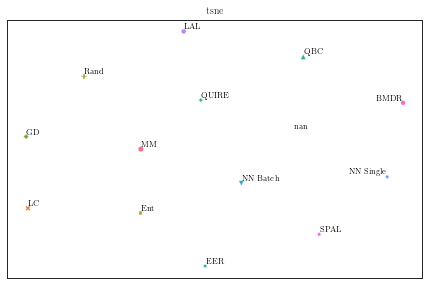

<Figure size 432x288 with 0 Axes>

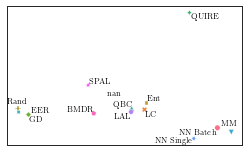

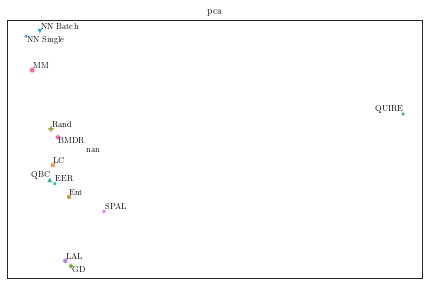

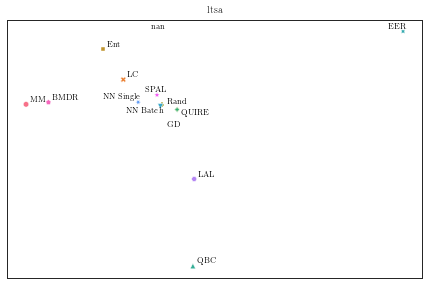

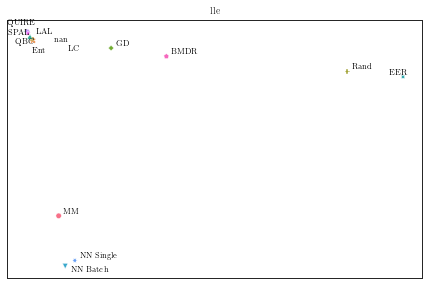

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from adjustText import adjust_text

strategy_results = []
strategy_results.append(dataset_names)



def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(data=data, x=x, y=y, legend=False, hue='strategies', style='strategies',s=30)

    # Add text besides each point
    texts = []
    for line in range(0,data.shape[0]):
         texts.append(p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold'))
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    p1.tick_params(left=False, bottom=False) 
    p1.set(xticklabels=[])
    p1.set(yticklabels=[])
    adjust_text(texts)
    return p1


for strategy in df['strategy'].unique():
    results = [strategy]
    for dataset in df['dataset_id'].unique():
        results.append("{:.40f}".format(df.loc[(df['dataset_id']==dataset) & (df['strategy']==strategy)]['f1_auc'].mean()))
        
        results = [r if r != "nan" else -0 for r in results] 
        
    strategy_results.append(results)

results_df = pd.DataFrame(strategy_results[1:], columns=strategy_results[0])
results_df = results_df.set_index("strategy")
results_df = results_df.replace(0, np.NaN)
results_df = results_df.apply(pd.to_numeric)
results_df = results_df.fillna(results_df.mean())

print(results_df)



results_df['mean'] = results_df.T.mean(skipna=True)
results_df=(results_df-results_df.mean())/results_df.std()
#results_df=(results_df-results_df.min())/(results_df.max()-results_df.min())




results_df = results_df.T


cosine_similarities = cosine_similarity([results_df['NN Single'].to_numpy()], results_df.T.to_numpy())
#for al_strat, cosine in sorted(zip(results_df.columns, cosine_similarities[0]), key=lambda t: t[1], reverse=True):
#    print("{:<10}: {:>.4f}".format(al_strat, cosine))


from sklearn.manifold import TSNE
from sklearn import manifold
from sklearn.decomposition import TruncatedSVD

tsne = TSNE(n_components=2, init='pca', random_state=0)    
X_tsne = tsne.fit_transform(results_df.T.to_numpy())  
X_pca = TruncatedSVD(n_components=2).fit_transform(results_df.T.to_numpy())

tsne_df = pd.DataFrame(X_tsne, columns=['X', 'Y'])
tsne_df['strategies'] = results_df.columns
g = scatter_text('X', 'Y', 'strategies',
             data = tsne_df, 
             title = 'tsne', 
             xlabel = '',
             ylabel = '')
g.get_figure().savefig('../paper/figures/tsne.png', format='png', bbox_inches='tight')
plt.figure()
plt.clf()
n_neighbors = 3

X = results_df.T.to_numpy()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(X)
X_lle = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method='standard').fit_transform(X)
X_mlle = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method='modified').fit_transform(X)
#X_hlle = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='hessian').fit_transform(X)
X_ltsa = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method='ltsa').fit_transform(X)
X_mds = manifold.MDS(n_components=2, n_init=1, max_iter=100).fit_transform(X)

#pca, lle, iso, ltsa

tsne_df = pd.DataFrame(X_iso, columns=['Y', 'X'])
tsne_df['strategies'] = results_df.columns

plt.figure(figsize=set_size(width, fraction=0.5))
g = scatter_text('X', 'Y', 'strategies',
             data = tsne_df, 
             title = '', 
             xlabel = '',
             ylabel = '')
g.get_figure().savefig('../paper/figures/iso.png', format='png', bbox_inches='tight')
g.get_figure().savefig('../paper/figures/iso.pdf', format='pdf', bbox_inches='tight')

plt.figure()
plt.clf()


tsne_df = pd.DataFrame(X_pca, columns=['X', 'Y'])
tsne_df['strategies'] = results_df.columns

g = scatter_text('X', 'Y', 'strategies',
             data = tsne_df, 
             title = 'pca', 
             xlabel = '',
             ylabel = '')
g.get_figure().savefig('../paper/figures/pca.png', format='png', bbox_inches='tight')

plt.figure()
plt.clf()


tsne_df = pd.DataFrame(X_ltsa, columns=['X', 'Y'])
tsne_df['strategies'] = results_df.columns

g = scatter_text('X', 'Y', 'strategies',
             data = tsne_df, 
             title = 'ltsa', 
             xlabel = '',
             ylabel = '')
g.get_figure().savefig('../paper/figures/ltsa.png', format='png', bbox_inches='tight')

plt.figure()
plt.clf()

#plt.figure(figsize=set_size(width, fraction=0.5))
tsne_df = pd.DataFrame(X_lle, columns=['X', 'Y'])
tsne_df['strategies'] = results_df.columns

g = scatter_text('X', 'Y', 'strategies',
             data = tsne_df, 
             title = 'lle', 
             xlabel = '',
             ylabel = '')
g.get_figure().savefig('../paper/figures/lle.png', format='png', bbox_inches='tight')
g.get_figure().savefig('../paper/figures/lle.pdf', format='pdf', bbox_inches='tight')


5088


findfont: Font family ['times'] not found. Falling back to DejaVu Sans.


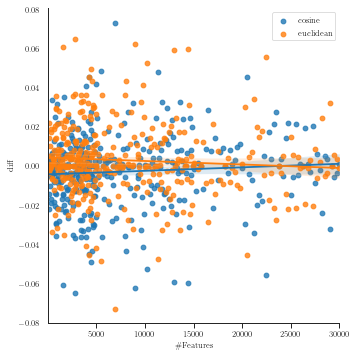

In [ ]:
df3 = pd.read_csv("../datasets/ali_cos_vs_sin_test/result.csv")
print(len(df3))

df3['strategy'] = df3['strategy'].map({
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '../datasets/ali_cos_vs_sin_test/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'cosine', 'STATE_INCLUDE_NR_FEATURES': False}": 'Cosine',
    "<class '__main__.ANNQuerySingle'>{'NN_BINARY_PATH': '../datasets/ali_cos_vs_sin_test/single_10.pickle', 'HYPER_SAMPLING_SEARCH_ITERATIONS': 10, 'TRUE_DISTANCES': True, 'DISTANCE_METRIC': 'euclidean', 'STATE_INCLUDE_NR_FEATURES': False}": 'Euclidean',
})

df3 = df3.drop_duplicates(subset=['strategy', 'n_features'], keep='last')

#df.rename(columns={'n_features': "\#Features", "f1_auc": 'F1 AUC'}, inplace=True)
#plt.figure(figsize=set_size(20*width, fraction=0.5))
#g = sns.lmplot(data=df, x="\#Features", y="F1 AUC", hue='strategy', y_jitter=0.01, logistic=True, legend=False)
#g
#exit(-1)

cosine_values = df3.loc[df3['strategy'] == 'Cosine'][['f1_auc', 'n_features']]
euclidean_values = df3.loc[df3['strategy'] == 'Euclidean'][['f1_auc', 'n_features']]
cosine_values.set_index('n_features', inplace=True)
euclidean_values.set_index('n_features', inplace=True)

#print(differences)
#print(cosine_values)

differences = (euclidean_values + cosine_values)/2
differences['cosine'] = cosine_values['f1_auc'] - differences['f1_auc']
differences['euclidean'] = euclidean_values['f1_auc'] - differences['f1_auc']
differences.reset_index(level=0, inplace=True)
differences = differences.melt(id_vars=["n_features", "f1_auc"], var_name="strategy", value_name="diff")

#print(differences)
differences.rename(columns={'n_features': "\#Features", "f1_auc": 'F1 AUC'}, inplace=True)
#print(differences)

g = sns.lmplot(data=differences, x="\#Features", y="diff", hue='strategy',legend=False)#, y_jitter=0.01, logistic=True, legend=False)
plt.legend(loc=1)
g